# Playing around with simple policy gradient methods

In [1]:
%load_ext autoreload

%autoreload 2


In [2]:
%matplotlib inline

import numpy as np
import gym
import sys
import time
from matplotlib import pyplot as plt
import logging
import torch
sys.path.append("../../")
from reinforcing_fun.agents import DrunkHamster, DiscretePolicyAgent, DiscreteActorCriticAgent, DQNAgent
from reinforcing_fun.training import ReinforceTrainer, MCActorCriticTrainer, TD0ActorCriticTrainer, DQNTrainer

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)


In [3]:
num_episodes = int(2e3)
env = gym.make("CartPole-v0")
agent = DQNAgent(env)

In [13]:
for x in agent.dqn_net_local.named_parameters() + agent.dqn_net_target.named_parameters():
    if "head_nets" in x[0]:
        print(x[0], x[1])

TypeError: unsupported operand type(s) for +: 'generator' and 'generator'

## Helper functions

In [6]:
def run_episode(env, agent, max_steps=1000, stop_when_done=True, render=True, fps=30):
    state = env.reset()
    reward = 0.
    episode_reward = 0.

    for _ in range(max_steps):
        if fps is not None:
            time.sleep(1./fps)
        if render:
            env.render()
        action = agent(state)[0]
        state, reward, done, info = env.step(action)
        episode_reward += reward

        if stop_when_done and done:
            if fps is not None:
                time.sleep(0.5)
            break
        
    return episode_reward
        

def run(env, agent, num_episodes=1, max_steps=1000, stop_when_done=True, render=True, fps=30):
    total_reward = 0.
    for _ in range(num_episodes):
        total_reward += run_episode(env, agent, max_steps, stop_when_done, render, fps)
    return total_reward


In [7]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

## Cart pole experiments

In [8]:
num_episodes = int(2e3)
env = gym.make("CartPole-v0")

agents = {}
rewards = {}
lengths = {}
losses = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train(agent_class, trainer_class, label, lr=1.e-3):
    agent = agent_class(env, 4)
    trainer = trainer_class(env, agent, lr=lr, device = device)
    reward, length, loss = trainer.train(
        num_episodes=num_episodes
    )
    
    agents[label] = agent
    rewards[label] = reward
    lengths[label] = length#
    losses[label] = loss / length[:,np.newaxis]

In [9]:
train(DQNAgent, DQNTrainer, "DQN")

Episode 2000,: reward = 9.31, losses = 1.33e+00: 100%|██████████| 2000/2000 [01:11<00:00, 27.81it/s]


In [ ]:
train(
    DiscretePolicyAgent, ReinforceTrainer,
    "REINFORCE"
)

In [ ]:
train(
    DiscreteActorCriticAgent, MCActorCriticTrainer,
    "MC actor-critic",
    critic_factor=10.
)

In [ ]:
train(
    DiscreteActorCriticAgent, TD0ActorCriticTrainer,
    "One-step actor-critic",
    critic_factor=10.
)

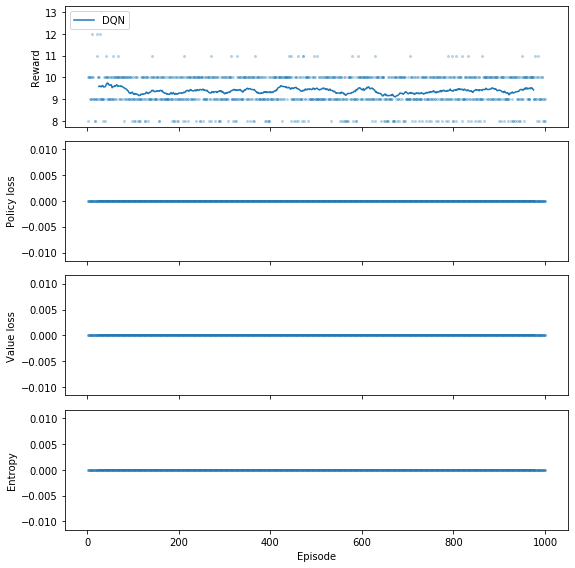

In [14]:
ticks = np.linspace(0., num_episodes, 6)
fig = plt.figure(figsize=(8,8))

ax = plt.subplot(4,1,1)
for i, (key, val) in enumerate(rewards.items()):
    plt.scatter(np.arange(1, num_episodes+1), val, c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(25, num_episodes-24), running_mean(val, 50), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.legend(loc="upper left")
plt.ylabel("Reward")
plt.xticks(ticks, labels=["" for _ in ticks])

ax = plt.subplot(4,1,2)
for i, (key, val) in enumerate(losses.items()):
    plt.scatter(np.arange(1, num_episodes+1), val[:,0], c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(25, num_episodes-24), running_mean(val[:,0], 50), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.ylabel("Policy loss")
plt.xticks(ticks, labels=["" for _ in ticks])

ax = plt.subplot(4,1,3)
for i, (key, val) in enumerate(losses.items()):
    plt.scatter(np.arange(1, num_episodes+1), val[:,1], c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(25, num_episodes-24), running_mean(val[:,1], 50), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.ylabel("Value loss")
plt.xticks(ticks, labels=["" for _ in ticks])

ax = plt.subplot(4,1,4)
for i, (key, val) in enumerate(losses.items()):
    plt.scatter(np.arange(1, num_episodes+1), - val[:,2], c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(25, num_episodes-24), running_mean(- val[:,2], 50), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.ylabel("Entropy")
plt.xlabel("Episode")
plt.xticks(ticks)

plt.tight_layout()
plt.savefig("policy_gradient_cartpole.pdf")


In [ ]:
run(env, agents["REINFORCE"])

In [ ]:
env.close()

## Space Invaders

In [ ]:
env = gym.make("SpaceInvaders-ram-v0")

In [ ]:
acs = env.action_space

In [ ]:
acs.sample()

In [ ]:
env.reset()

In [ ]:
ret = env.step(3)


In [ ]:
env.close()

In [ ]:
num_episodes = 10000
env = gym.make("SpaceInvaders-ram-v0")

agents = {}
rewards = {}
lengths = {}
losses = {}

def train(agent_class, trainer_class, label, lr=1.e-3, critic_factor=1., entropy_factor=0.):
    agent = agent_class(env, 128)
    trainer = trainer_class(env, agent, lr=lr)
    reward, length, loss = trainer.train(
        num_episodes=num_episodes, critic_factor=critic_factor, entropy_factor=entropy_factor
    )
    
    agents[label] = agent
    rewards[label] = reward
    lengths[label] = length
    losses[label] = loss / length[:,np.newaxis]

In [ ]:
train(DiscretePolicyAgent, ReinforceTrainer, "REINFORCE")

In [ ]:
train(DiscreteActorCriticAgent, MCActorCriticTrainer, "MC actor-critic")

In [ ]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


ticks = np.linspace(0., num_episodes, 6)


fig = plt.figure(figsize=(8,8))

ax = plt.subplot(3,1,1)
for i, (key, val) in enumerate(rewards.items()):
    plt.scatter(np.arange(1, num_episodes+1), val, c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(50, num_episodes-49), running_mean(val, 100), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.legend(loc="upper left")
plt.ylabel("Reward")
plt.xticks(ticks, labels=["" for _ in ticks])

ax = plt.subplot(3,1,2)
for i, (key, val) in enumerate(lengths.items()):
    plt.scatter(np.arange(1, num_episodes+1), val, c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(50, num_episodes-49), running_mean(val, 100), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.ylabel("Episode length")
plt.xticks(ticks, labels=["" for _ in ticks])

ax = plt.subplot(3,1,3)
for i, (key, val) in enumerate(losses.items()):
    plt.scatter(np.arange(1, num_episodes+1), val, c="C{}".format(i), s=4., alpha=0.25, rasterized=True)
    plt.plot(np.arange(50, num_episodes-49), running_mean(val, 100), lw=1.5, label=key, c="C{}".format(i), zorder=1)
plt.ylabel("Mean loss")
plt.xlabel("Episode")
plt.xticks(ticks)

plt.tight_layout()
plt.savefig("policy_gradient_spaceinvaders.pdf")


In [ ]:
run(env, agents["REINFORCE"])

In [5]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
More about Reinforcement learning: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/
Dependencies:
torch: 0.4
gym: 0.8.1
numpy
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
env = gym.make('CartPole-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value


class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()

print('\nCollecting experience...')
for i_episode in range(400):
    s = env.reset()
    ep_r = 0
    while True:
        #env.render()
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)

        # modify the reward
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        #r = r1 + r2

        dqn.store_transition(s, a, r, s_)

        ep_r += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))

        if done:
            break
        s = s_


Ep:  202 | Ep_r:  11.0
Ep:  203 | Ep_r:  24.0
Ep:  204 | Ep_r:  13.0
Ep:  205 | Ep_r:  11.0
Ep:  206 | Ep_r:  32.0
Ep:  207 | Ep_r:  35.0
Ep:  208 | Ep_r:  32.0
Ep:  209 | Ep_r:  22.0
Ep:  210 | Ep_r:  9.0
Ep:  211 | Ep_r:  9.0
Ep:  212 | Ep_r:  10.0
Ep:  213 | Ep_r:  9.0
Ep:  214 | Ep_r:  12.0
Ep:  215 | Ep_r:  36.0
Ep:  216 | Ep_r:  8.0
Ep:  217 | Ep_r:  9.0
Ep:  218 | Ep_r:  11.0
Ep:  219 | Ep_r:  9.0
Ep:  220 | Ep_r:  17.0
Ep:  221 | Ep_r:  24.0
Ep:  222 | Ep_r:  26.0
Ep:  223 | Ep_r:  31.0
Ep:  224 | Ep_r:  14.0
Ep:  225 | Ep_r:  12.0
Ep:  226 | Ep_r:  21.0
Ep:  227 | Ep_r:  11.0
Ep:  228 | Ep_r:  10.0
Ep:  229 | Ep_r:  12.0
Ep:  230 | Ep_r:  9.0
Ep:  231 | Ep_r:  9.0
Ep:  232 | Ep_r:  11.0
Ep:  233 | Ep_r:  30.0
Ep:  234 | Ep_r:  34.0
Ep:  235 | Ep_r:  9.0
Ep:  236 | Ep_r:  8.0
Ep:  237 | Ep_r:  9.0
Ep:  238 | Ep_r:  9.0
Ep:  239 | Ep_r:  14.0
Ep:  240 | Ep_r:  15.0
Ep:  241 | Ep_r:  11.0
Ep:  242 | Ep_r:  10.0
Ep:  243 | Ep_r:  13.0
Ep:  244 | Ep_r:  10.0
Ep:  245 | Ep_r:  8.0


In [12]:
env.close()